# Find the most profitable arbitrage opportunity with QAOA
Given a market condition as a directed graph, find a closed cycle in the graph that represents the most profitable arbitrage opportunity. We solve this problem with Qiskit and the QAOA approach.

Here are some market conditions:

In [15]:
# No arbitrage opportunity
c_2_no_arbit = {
    ("EUR", "GBP"): 0.88,
    ("GBP", "EUR"): 1.13
}

# Arbitrage possible with just two assets
c_2_yes_arbit = {
    ("EUR", "GBP"): 0.88,
    ("GBP", "EUR"): 1.23
}

c_3_no_arbit = {
    ("EUR", "GBP"): 0.88,
    ("GBP", "EUR"): 1.13,
    ("EUR", "CAD"): 1.47,
    ("CAD", "EUR"): 0.68,
    ("GBP", "CAD"): 1.65,
    ("CAD", "GBP"): 0.6
}

# GBP -> EUR -> CAD -> GBP makes you money. The other cycles do not.
c_3_yes_arbit = {
    ("EUR", "GBP"): 0.88,
    ("GBP", "EUR"): 1.13,
    ("EUR", "CAD"): 1.58,
    ("CAD", "EUR"): 0.61,
    ("GBP", "CAD"): 1.65,
    ("CAD", "GBP"): 0.6
}


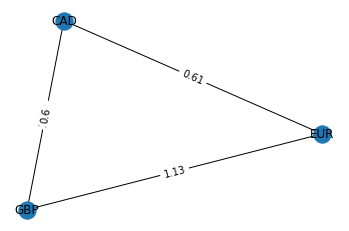

In [39]:
%matplotlib inline

import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

plot_this = c_3_yes_arbit

G.add_edges_from(list(plot_this.keys()))

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=plot_this)
plt.axis('off')
plt.show()

Some useful functions:

In [ ]:
import numpy as np
from qiskit import BasicAer as Aer
from qiskit import QuantumRegister, execute
from qiskit.quantum_info import Pauli
from qiskit.aqua import Operator, get_aer_backend
from qiskit.aqua.components.initial_states import Custom
from scipy.optimize import minimize

def pauli_x(q, coeff, n):
    eye = np.eye((n)) # the i^th row of the identity matrix is 
                      # the correct parameter for \sigma_i 
    return Operator([[coeff, Pauli(np.zeros(n), eye[q])]])

def pauli_z(q, coeff, n):
    eye = np.eye((n))
    return Operator([[coeff, Pauli(eye[q], np.zeros(n))]])

def product_pauli_z(q1, q2, coeff, n):
    eye = np.eye((n))
    return Operator([[coeff, Pauli(eye[q1], np.zeros(n)) *
                      Pauli(eye[q2], np.zeros(n))]])

In [ ]:
def evolve(hamiltonian, angle, quantum_registers):
    return hamiltonian.evolve(None, angle, 'circuit', 1,
                              quantum_registers=quantum_registers,
                              expansion_mode='suzuki',
                              expansion_order=3)

def create_circuit(beta, gamma, Hc, Hm, qr, circuit_init, n_qubits):
    identity = pauli_x(0, 0, n_qubits)
    p = len(gamma)
    circuit_evolv = sum([evolve(Hc, beta[i], qr) + evolve(Hm, gamma[i], qr)
                            for i in range(p)], evolve(identity, 0, qr))
    circuit = circuit_init + circuit_evolv
    return circuit

def evaluate_circuit(beta, gamma, Hc, Hm, qr, circuit_init, n_qubits):
    circuit = create_circuit(beta, gamma, Hc, Hm, qr, circuit_init, n_qubits)
    return np.real(Hc.eval("matrix", circuit,
                   get_aer_backend('statevector_simulator'))[0])

The market condition is represented as a cost Hamiltonian:

In [ ]:
def get_cost_hamiltonian(rates, m1, m2): # ordered dict
    n = len(rates)
    assets = set(k for k, v in rates.keys())
    operators = []
    for i, r in enumerate(rates.values()):
        operators.append(pauli_z(i, np.log(r), n))
    print(rates)
    for a in assets:
        for i, k in enumerate(rates.keys()):
            print(k)
            x1, y1 = k
            if x1 != a: continue
            for j, (x2, y2) in enumerate(rates.keys()):
                if x2 != a: continue
                operators.append(product_pauli_z(i, j, -m1, n))
            for j, (x2, y2) in enumerate(rates.keys()):
                if y2 != a: continue
                operators.append(product_pauli_z(i, j, 2 * m1, n))
        for i, (x1, y1) in rates.keys:
            if y1 != a: continue
            for j, (x2, y2) in enumerate(rates.keys()):
                if y2 != a: continue
                operators.append(product_pauli_z(i, j, -m1, n))
    for a in assets:
        for i, (x1, y1) in enumerate(rates.keys()):
            if x1 != a: continue
            operators.append(pauli_z(i, m2, n))
            for j, (x2, y2) in enumerate(rates.keys()):
                if x2 != a: continue
                operators.append(product_pauli_z(i, j, -m2, n))
    identity = pauli_x(0, 0, n)
    Hc = sum(operators, identity)
    Hc.to_matrix()
    return Hc

In [ ]:
def get_mixing_hamiltonian(n):
    identity = pauli_x(0, 0, n)

    Hm = sum([pauli_x(i, -1, n) for i in range(n)], identity)
    Hm.to_matrix()
    return Hm

Actually running the whole thing:

In [ ]:
rates = c_2_yes_arbit
n_iter = 10 # number of iterations of the optimization procedure
p = 1
beta = np.random.uniform(0, np.pi*2, p)
gamma = np.random.uniform(0, np.pi*2, p)
n = len(rates)
init_state_vect = [1 for i in range(2 ** n)]
init_state = Custom(n, state_vector=init_state_vect)
qr = QuantumRegister(n)
circuit_init = init_state.construct_circuit('circuit', qr)
Hc = get_cost_hamiltonian(rates, 1, 1)
Hm = get_mixing_hamiltonian(n)

result = minimize(lambda x: evaluate_circuit(x[:(len(x) / 2)],
                                             x[(len(x) / 2):],
                                             Hc, Hm, qr, circuit_init, n),
                  np.concatenate([beta, gamma]),
                  method='L-BFGS-B')

circuit = create_circuit(result['x'][:p], result['x'][p:])

backend = Aer.get_backend('statevector_simulator')
job = execute(circuit, backend)
state = np.asarray(job.result().get_statevector(circuit))
